## **Feature Exploration**
- Discovering which features are important
- Need to annotate further later

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Initialize
accounts = pd.read_csv('Files_CSV/HI-Small_accounts.csv')
transactions = pd.read_csv('Files_CSV/HI-Small_Trans.csv')

# Column Names Change
transactions.rename(columns={'Account': 'Acc. Orig.', 'Account.1': 'Acc. End'}, inplace=True)

# Change Data Types
col_to_int = ['From Bank', 'To Bank', 'Is Laundering']
col_to_float = ['Amount Received', 'Amount Paid']
transactions[col_to_int] = transactions[col_to_int].astype(int)
transactions[col_to_float] = transactions[col_to_float].astype(float)
transactions['Timestamp'] = pd.to_datetime(transactions['Timestamp'])

# Drop Columns
trans_drop = transactions.drop('Timestamp', axis=1)

# Split Columns
accounts[['Bank Name (2)', 'Bank Name (3)']] = accounts['Bank Name'].str.split('#', n=1, expand=True)
accounts[['Entity Name (2)', 'Entity Name (3)']] = accounts['Entity Name'].str.split('#', n=1, expand=True)

# Merge SpreadSheets
merged_df = pd.merge(trans_drop, accounts, left_on='Acc. End', right_on='Account Number', how='left')

# Fraud vs Non-Fraud
fraud_false = merged_df[merged_df['Is Laundering'] == 0] # 5,073,168
fraud_true = merged_df[merged_df['Is Laundering'] == 1] # 5,177

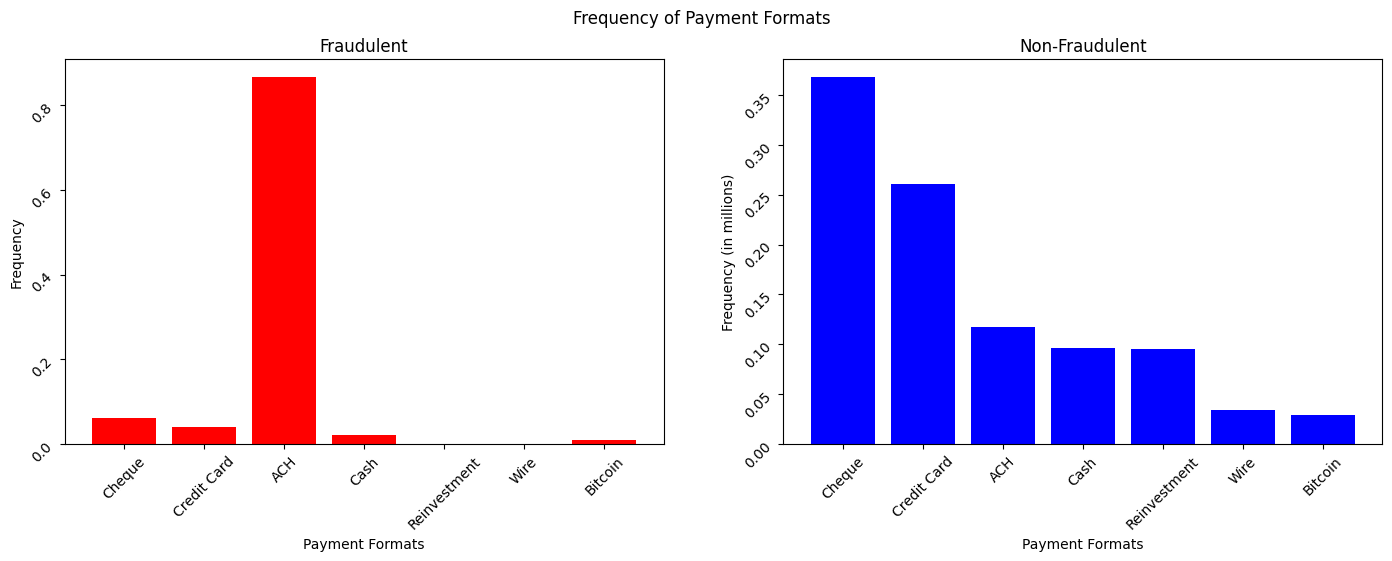

In [3]:
# --- Bar Chart ---
# ACH payment format shows it contains the most fraudulent charges
bar_fraud = fraud_true['Payment Format'].value_counts(normalize=True)
bar_trans = fraud_false['Payment Format'].value_counts(normalize=True)

common_index = bar_trans.index
bar_fraud = bar_fraud.reindex(common_index, fill_value=0)
bar_trans = bar_trans.reindex(common_index, fill_value=0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))
fig.suptitle('Frequency of Payment Formats')

ax1.bar(bar_fraud.index, bar_fraud.values, color='red')
ax1.set_title('Fraudulent')
ax1.set_xlabel('Payment Formats')
ax1.set_ylabel('Frequency')
ax1.tick_params(rotation=45)

ax2.bar(bar_trans.index, bar_trans.values, color='blue')
ax2.set_title('Non-Fraudulent')
ax2.set_xlabel('Payment Formats')
ax2.set_ylabel('Frequency (in millions)')
ax2.tick_params(rotation=45)

plt.show()

#### *ACH charges are highly predictive*

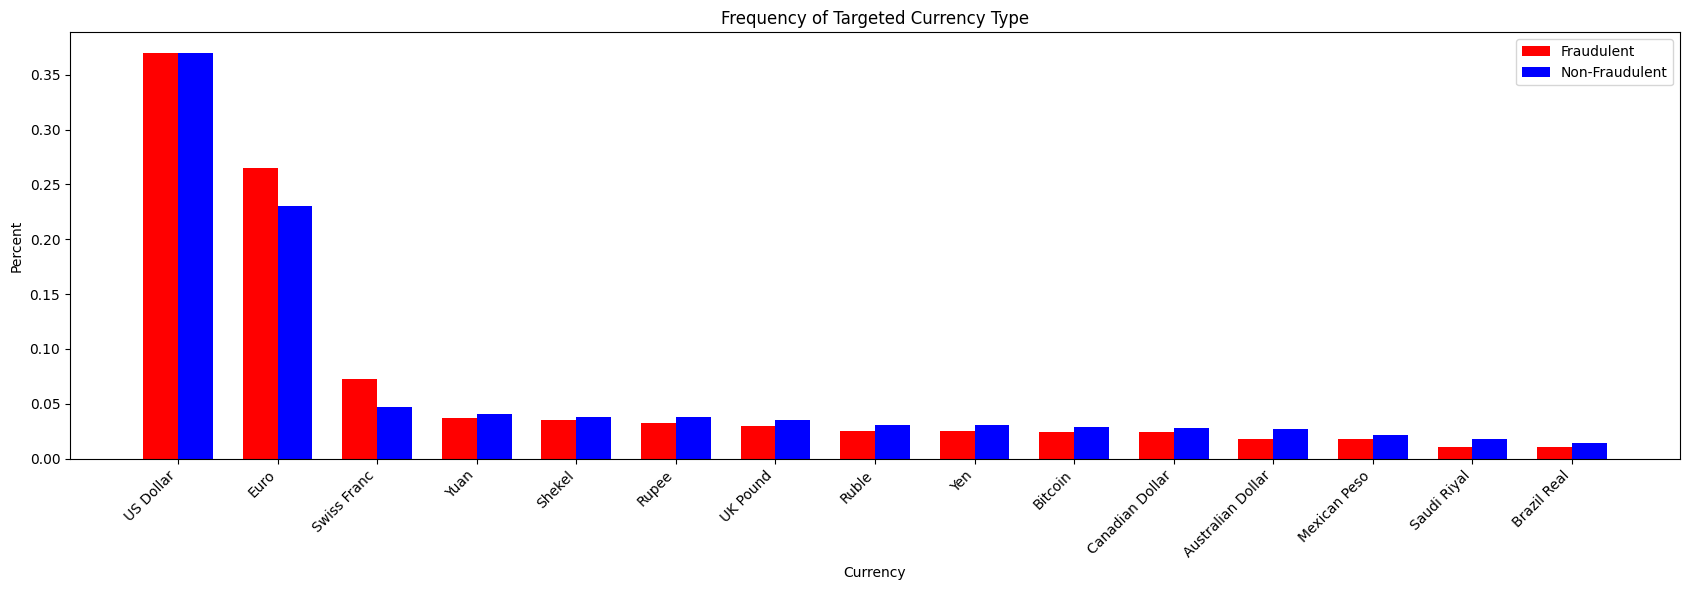

In [4]:
# --- Bar Chart 2 ---

bar2_fraud = fraud_true['Receiving Currency'].value_counts(normalize=True)
bar2_trans = fraud_false['Receiving Currency'].value_counts(normalize=True)
common_index = bar2_trans.index

x = np.arange(len(common_index))
width = 0.35

plt.figure(figsize=(17, 6))
plt.bar(x - width/2, bar2_fraud.values, width, color='red', label='Fraudulent')
plt.bar(x + width/2, bar2_trans.values, width, color='blue', label='Non-Fraudulent')

plt.xticks(x, common_index, rotation=45, ha='right')

plt.title('Frequency of Targeted Currency Type')
plt.xlabel('Currency')
plt.ylabel('Percent')
plt.legend()
plt.tight_layout()

plt.show()

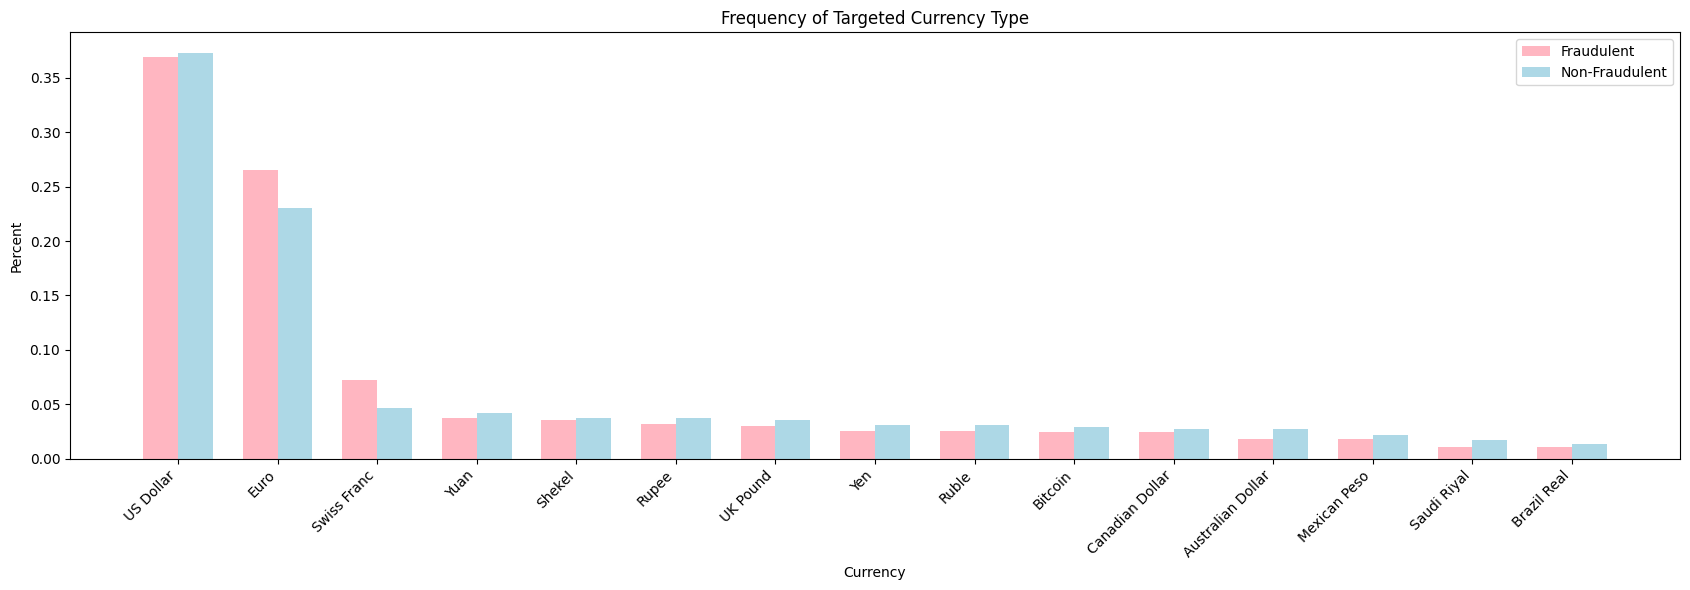

In [ ]:
# --- Bar Chart 2 ---

bar3_fraud = fraud_true['Payment Currency'].value_counts(normalize=True)
bar3_trans = fraud_false['Payment Currency'].value_counts(normalize=True)
common_index = bar3_trans.index

x = np.arange(len(common_index))
width = 0.35

plt.figure(figsize=(17, 6))
plt.bar(x - width/2, bar3_fraud.values, width, color='lightpink', label='Fraudulent')
plt.bar(x + width/2, bar3_trans.values, width, color='lightblue', label='Non-Fraudulent')

plt.xticks(x, common_index, rotation=45, ha='right')

plt.title('Frequency of Payment Currency Type')
plt.xlabel('Currency')
plt.ylabel('Percent')
plt.legend()
plt.tight_layout()

plt.show()

#### *Currency Type is not highly predicitve for received and payed currency types*

In [6]:
# --- To/From Bank Analysis ---
fraud_bank_diff = fraud_true[fraud_true['From Bank'] != fraud_true['To Bank']]
fraud_bank_per = (float(len(fraud_bank_diff)) / float(len(fraud_true))) * 100

all_bank_diff = fraud_false[fraud_false['From Bank'] != fraud_false['To Bank']]
all_bank_per = (float(len(all_bank_diff)) / float(len(fraud_false))) * 100

diff_per = fraud_bank_per - all_bank_per

print(f'Fraudulent Charges: {fraud_bank_per:.2f}%')
print(f'All Charges: {all_bank_per:.2f}%')
print(f'Percent Difference: {diff_per:.2f}%')

Fraudulent Charges: 98.01%
All Charges: 86.37%
Percent Difference: 11.64%


#### *Different 'from' and 'to' banks is relatively predictive*

In [7]:
acc_bank = accounts['Bank ID'].drop_duplicates()
fraud_bank = fraud_true['To Bank'].drop_duplicates()
trans_bank = fraud_false['From Bank'].drop_duplicates()
present_values = fraud_bank.isin(trans_bank)

print('Total Banks in each dataset')
print(f'Accounts: {len(acc_bank)}')
print(f'Transactions: {len(trans_bank)}')
print(f'Fraud Transactions: {len(fraud_bank)}')
print(f'# Banks that appear in Fraud & Non-Fraud: {len(present_values)}')

Total Banks in each dataset
Accounts: 30470
Transactions: 30470
Fraud Transactions: 1105
# Banks that appear in Fraud & Non-Fraud: 1105


Small subset of banks is disproportionally in non-fraudulent transactions

In [8]:
acc2_bank = accounts['Account Number'].drop_duplicates()
fraud2_bank = fraud_true['Acc. End'].drop_duplicates()
trans2_bank = fraud_false['Acc. End'].drop_duplicates()
present2_values = fraud2_bank.isin(trans2_bank)

print('Total Accounts in each dataset')
print(f'Accounts: {len(acc2_bank)}')
print(f'Transactions: {len(trans2_bank)}')
print(f'Fraud Transactions: {len(fraud2_bank)}')
print(f'# Banks that appear in Fraud & Non-Fraud: {len(present2_values)}')

Total Accounts in each dataset
Accounts: 518573
Transactions: 420585
Fraud Transactions: 3984
# Banks that appear in Fraud & Non-Fraud: 3984


Similar to comparing banks, there is only a limited number of accounts that are fraudulent

In [15]:
entity_true = fraud_true['Entity Name (2)'].value_counts(normalize=True)
entity_false = fraud_false['Entity Name (2)'].value_counts(normalize=True)
print(entity_false)
print(entity_true)

Entity Name (2)
Partnership             0.353164
Sole Proprietorship     0.334511
Corporation             0.297584
Country                 0.014105
Individual              0.000598
Direct                  0.000039
Name: proportion, dtype: float64
Entity Name (2)
Partnership             0.359088
Corporation             0.319876
Sole Proprietorship     0.316979
Country                 0.004056
Name: proportion, dtype: float64
